## Домашнее задание №2: Глубинные нейронные сети. Pytorch

### Пожалуйста, заполните имя

In [2]:
STUDENT_NAME = "Andrey Tomashev" # For example, Fedor Petriaikin

In [3]:
# Включает режим проверки
try:
    import train_utils
    TEST_MODE = True
except:
    TEST_MODE = False

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh
import torch.nn as nn
from torch import Tensor
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать обучить нейронную сеть с помощью фреймворка Pytorch, изучить подходы к инициализации нейронных сетей и реализовать слои, улучшающие сходимость глубинных нейронных сетей.

### Часть 1. Введение в Pytorch

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица.  
Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.  

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


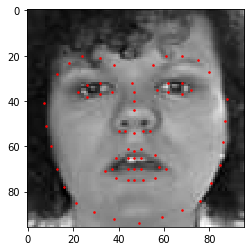

In [5]:
# Пример работы с датасетом

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [6]:
# Далее нам нужно сформировать свой датасет
# См. https://pytorch.org/docs/stable/torchvision/datasets.html

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    # Из этой функции нужно вернуть dict вида {'image': image, 'landmarks': landmarks}
    # Где image и landmarks - получаются так же, как в функции выше
    # Не забудьте применить transform - это нужно для превращения в тензор
    def __getitem__(self, idx):
        ### YOUR CODE HERE
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
# Превращение в torch.Tensor лучше делать как отдельное преобразование -
# это позволит работать с датасетом не только в рамках pytorch
# Выходом преобразования должны быть (X, y) - 2 одномерных тензора torch.FloatTensor
# Для этого воспользуйтеь методом ndarray.ravel()
# Получающиеся размерности X = torch.Size([9216]), y = torch.Size([136])

# Обратите внимание на типы тензоров в pytorch! Это очень важный их параметр!
# См. https://pytorch.org/docs/stable/tensors.html#torch.Tensor.type

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    # Превращает во FloatTensor входные данные и "вытягивает" размерности в одну строку
    # (т.к. у нас не сверточные сети - нет смысла хранить размерности)
    def __call__(self, sample):
        ### YOUR CODE HERE
        image, landmarks = sample['image'], sample['landmarks']
        #image = image.transpose((2, 0, 1))
        image = image.ravel()
        
        landmarks = landmarks.ravel()
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [8]:
# Если не отделять папку dataset от этого notebook, то этот код
# 1) должен создать train и test
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor() # Чтобы получить тензоры
                                     )
test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

# 2) сформировать dataloader-ы 
# См. https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True)

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid). Loss - MSE, оптимизатор - Adam с learning rate 0.1 (остальные параметры оптимизатора по умолчанию). Обучайте сети в течении 4 эпох - нам не нужно здесь качество  
Для каждой архитектуры постройте графики для функции потерь на train/test


В этом задании **нет** порога качества - оно нужно, чтобы освоиться с pytorch

In [13]:
def simple_train(network, train_dataloader, test_dataloader, epochs):
    optimizer = torch.optim.Adam(network.parameters(), lr=0.1)
    mse_loss = MSELoss()
    ### YOUR CODE HERE
    loss_hist_train = []
    loss_hist_test = []
    for i in range(epochs):
        # Training
        for _, sample_batched in enumerate(train_dataloader):
            X_train = sample_batched['image'].float().cuda()
            y_train = sample_batched['landmarks'].float().cuda()
            y_pred = network(X_train)
            loss = mse_loss(y_pred, y_train)
            loss_hist_train.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        
    with torch.set_grad_enabled(False):
        for _, sample_batched in enumerate(test_dataloader):
            X_test = sample_batched['image'].float().cuda()
            y_test = sample_batched['landmarks'].float().cuda()
            y_pred_test = network(X_test)
            loss = mse_loss(y_pred_test, y_test)
            loss_hist_test.append(loss)

    fig = plt.figure()
    plt.plot(range(len(loss_hist_train)), loss_hist_train)             
    fig = plt.figure()
    plt.plot(range(len(loss_hist_test)), loss_hist_test)   

In [14]:
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti'

In [15]:
# Массив из nn.Sequential - сетей для обучения
networks = [] ### YOUR CODE HERE
H = 100

networks.append(Sequential(
                        Linear(9216, H),
                        Sigmoid(),
                        Linear(H, 136)
                        ).cuda())

networks.append(Sequential(
                         Linear(9216, H),
                        Tanh(),
                        Linear(H, 136)
                        ).cuda())

networks.append(Sequential(
                        Linear(9216, H),
                        nn.ReLU(),
                        Linear(H, 136)
                        ).cuda())
                        

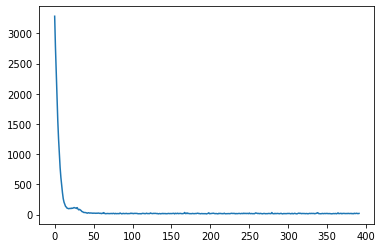

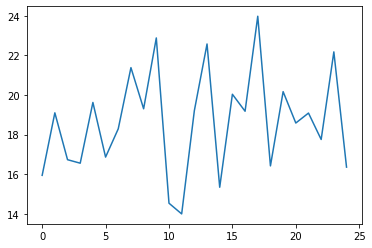

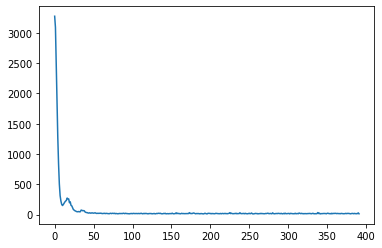

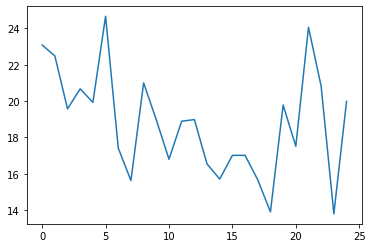

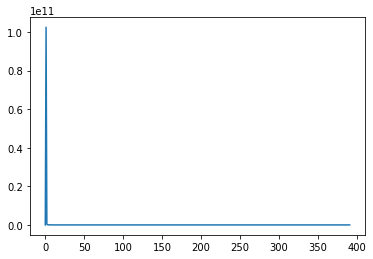

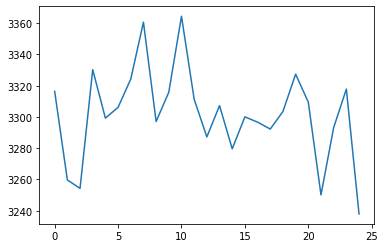

In [16]:
# Должен построить графики и написать значение MSE на train и test для каждой из архитектур
for n in networks:
    simple_train(n, train_dataloader, test_dataloader, 4)

In [13]:
# Проверка
if TEST_MODE:
    from importlib import reload
    reload(train_utils)

    for n in networks:
        train_utils.train(n, train_dataloader, test_dataloader, 4, MSELoss())

In [14]:
# Посмотрим на предикт

def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batch['image']
    landmarks_batch = sample_batch['landmarks']
    
    print(images_batch)
    batch_size = len(images_batch)

    images_batch = images_batch.view(-1, 96, 96)
    landmarks_batch = landmarks_batch.view(-1, 68, 2)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

tensor([[ 18,  19,  23,  ..., 255, 255, 255],
        [ 19,  20,  19,  ..., 212, 212, 213]], dtype=torch.uint8)


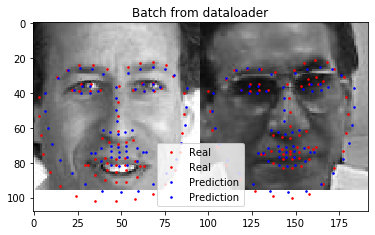

In [17]:
final_nw_pos = networks[0] # Выберите номер лучшей архитектуры в списке networks

test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
batch = next(iter(test_dataloader))
x = batch['image'].float().cuda()
y_pred = networks[0](x)
y = batch['landmarks'].float().cuda()
y_pred = y_pred.view(-1, 68, 2).cpu()
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

### Часть 2. Инициализация нейронных сетей
В этом задании мы вернемся к нашему знакомому датасету MNIST. Напомним:

In [18]:
from torchvision.datasets import MNIST

to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [19]:
# Тестовые батчи. Нарисуем их, а потом будем пропускать их через нейронную сеть
images_train, labels_train = next(iter(train_loader))

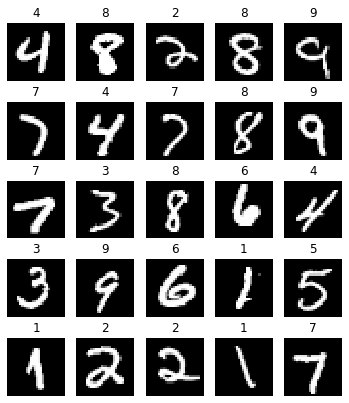

In [20]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_train.numpy()[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(labels_train.numpy()[i])
    plt.axis('off')

In [1]:
# Нам понадобятся некоторые вспомогательные функции для распечатки градиентов

ITER = 0
def forward_hook(self, input_, output):
    global ITER
    std = input_[0].std().item()
    print(ITER, ': forward', std)
    ITER += 1

def backward_hook(self, grad_input, grad_output):
    global ITER
    std = grad_input[0].std().item()
    print(ITER, ': backward', std)
    ITER -= 1

# Пользоваться ими можно так (пример функтора создания слоя)
def create_sample_linear(inp_size, out_size):
    layer = nn.Linear(inp_size, out_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=0.1)
    return layer

In [22]:
# Функция пропуска тестового батча через нейронную сеть
def sample_propagation(network):
    global ITER
    ITER = 0

    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1)
    y = labels_train[:n_objects]
    print(X.shape, y.shape)

    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [23]:
# Функция создания тестовой нейронной сети. Следует создавать 200 промежуточных слоев (и activation между ними)
# Принимает функторы создания слоев с "говорливыми" hook-ами (см. пример функтора создания слоя выше),
# возвращает nn.Sequential из них
# Не забывайте про *list для распаковки списков в параметры

# layers_creator - принимает массив, добавляет в него новый линейный промежуточный слой 500x500
# start_layer_creator - принимает массив, добавляет в него первый слой (784 --> 500)
# end_layer_creator - принимает массив, добавляет в него последний слой (500 --> 10)

def create_network(layers_creator=lambda layers: layers.append(create_sample_linear(500, 500)),
                   start_layer_creator=lambda layers: layers.append(create_sample_linear(784, 500)),
                   end_layer_creator=lambda layers: layers.append(create_sample_linear(500, 10)),
                   activation= nn.Tanh()):
    ### YOUR CODE HERE
    list = []
    activation_creator = lambda layers: layers.append(activation)
    start_layer_creator(list)
    for i in range(200):
        layers_creator(list)
        activation_creator(list)
    end_layer_creator(list)
    return Sequential(*list)
    

Сделайте функторы создания слоев (линейных, 500x500):  
1. Инициализированных N(0, 0.1) - см. create_sample_linear
2. Инициализированных по He
3. Инициализированных по Xavier

Обучите нейронные сети с каждым из методов инициализации. Архитектура - 784 -> 500 x (200 раз) -> 10. В качестве активации возьмите tanh (1-2), ReLU (Xavier). Посмотрите как изменяются градиенты на forward и backward (с помощью sample_propagation). Сделайте выводы

In [24]:
### YOUR CODE HERE

from torch.nn.init import xavier_uniform_, kaiming_uniform_

def create_sample_linear_He(inp_size, out_size):
    layer = nn.Linear(inp_size, out_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight = kaiming_uniform_(weight)
    return layer

def create_sample_linear_Xavier(inp_size, out_size):
    layer = nn.Linear(inp_size, out_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight = xavier_uniform_(weight)
    return layer

In [25]:
start_layer_creator_Xavier=lambda layers: layers.append(create_sample_linear_xav(784, 500))
end_layer_creator_Xavier=lambda layers: layers.append(create_sample_linear_xav(500, 10))

start_layer_creator_He = lambda layers: layers.append(create_sample_linear_he(784, 500))
end_layer_creator_He = lambda layers: layers.append(create_sample_linear_he(500, 10))

In [26]:
network = create_network()
network_Xavier = create_network(layers_creator=lambda layers: layers.append(create_sample_linear_Xavier(500, 500)),
                                start_layer_creator=lambda layers: layers.append(create_sample_linear_Xavier(784, 500)),
                                end_layer_creator=lambda layers: layers.append(create_sample_linear_Xavier(500, 10)),
                                )
network_He = create_network(layers_creator=lambda layers: layers.append(create_sample_linear_He(500, 500)),
                            start_layer_creator=lambda layers: layers.append(create_sample_linear_He(784, 500)),
                            end_layer_creator=lambda layers: layers.append(create_sample_linear_He(500, 10)),
                            activation= nn.ReLU())

In [27]:
sample_propagation(network)

torch.Size([100, 784]) torch.Size([100])
0 : forward 1.0021846294403076
1 : forward 2.8212244510650635
2 : forward 0.9329565167427063
3 : forward 0.8046544194221497
4 : forward 0.7734273076057434
5 : forward 0.7674708962440491
6 : forward 0.7633047699928284
7 : forward 0.7650787830352783
8 : forward 0.765200674533844
9 : forward 0.7667577862739563
10 : forward 0.7650637626647949
11 : forward 0.7630244493484497
12 : forward 0.7640892267227173
13 : forward 0.7649465203285217
14 : forward 0.7674578428268433
15 : forward 0.7679914832115173
16 : forward 0.7649742364883423
17 : forward 0.7647014856338501
18 : forward 0.7642480731010437
19 : forward 0.7659866809844971
20 : forward 0.7659274339675903
21 : forward 0.7644015550613403
22 : forward 0.7666949033737183
23 : forward 0.7643381357192993
24 : forward 0.7645335793495178
25 : forward 0.7673790454864502
26 : forward 0.7676879167556763
27 : forward 0.7663604617118835
28 : forward 0.7654902338981628
29 : forward 0.7642912864685059
30 : forwa

In [28]:
sample_propagation(network_Xavier)

torch.Size([100, 784]) torch.Size([100])
0 : forward 1.0021846294403076
1 : forward 1.1008177995681763
2 : forward 0.6500148177146912
3 : forward 0.49933236837387085
4 : forward 0.41053417325019836
5 : forward 0.35753047466278076
6 : forward 0.3235359489917755
7 : forward 0.2952049970626831
8 : forward 0.2750950753688812
9 : forward 0.2564827799797058
10 : forward 0.24209991097450256
11 : forward 0.23109830915927887
12 : forward 0.21795906126499176
13 : forward 0.20748662948608398
14 : forward 0.19869491457939148
15 : forward 0.19292837381362915
16 : forward 0.1868973970413208
17 : forward 0.18267183005809784
18 : forward 0.1773211807012558
19 : forward 0.16985546052455902
20 : forward 0.16547492146492004
21 : forward 0.16253216564655304
22 : forward 0.15773965418338776
23 : forward 0.15327146649360657
24 : forward 0.1499984860420227
25 : forward 0.14751222729682922
26 : forward 0.1451021134853363
27 : forward 0.14151358604431152
28 : forward 0.13763581216335297
29 : forward 0.13532365

In [29]:
sample_propagation(network_He)

torch.Size([100, 784]) torch.Size([100])
0 : forward 1.0021846294403076
1 : forward 1.415765404701233
2 : forward 1.154947280883789
3 : forward 1.1430343389511108
4 : forward 1.165138840675354
5 : forward 1.2271894216537476
6 : forward 1.287794589996338
7 : forward 1.3157914876937866
8 : forward 1.296869158744812
9 : forward 1.2857307195663452
10 : forward 1.2914011478424072
11 : forward 1.3618320226669312
12 : forward 1.28109872341156
13 : forward 1.2116864919662476
14 : forward 1.2421305179595947
15 : forward 1.292641282081604
16 : forward 1.23166823387146
17 : forward 1.1603490114212036
18 : forward 1.1271315813064575
19 : forward 1.123570203781128
20 : forward 1.093608021736145
21 : forward 1.049385905265808
22 : forward 1.0570921897888184
23 : forward 0.966927707195282
24 : forward 0.9498313665390015
25 : forward 0.9824278950691223
26 : forward 1.028311848640442
27 : forward 1.0310264825820923
28 : forward 0.9509643316268921
29 : forward 0.9311641454696655
30 : forward 0.936825275

*Выводы:*

Сравнивая последние две модели с первой, можно заметить, что стандартное отклонение для градиентов (как для forward так и для backward) имеет гораздо меньший разброc. Это говорит о взрыве градиентов, от которого Xavier и He защищены. Xavier используется, когда функци дифференцируема в нуле(поэтому используем с Tanh). Не для недифференцируемых соответственно(с ReLU). 

Спасибо за выполнение заданий!  

**Обратите внимание:**  
Еще 2 обязательных задания этого модуля - batchnorm и dropout - находятся в следующем jupyter notebook (скоро будет отправлен). Также будет отправлено необязательное задание по методам оптимизации